In [1]:
import pandas as pd
from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms

In [2]:
survival_data_path = '/Users/jk1/Library/CloudStorage/OneDrive-unige.ch/stroke_research/geneva_stroke_incidence/data/PPGSS_3_KM_R2.xlsx'
# survival_data_path = '/Users/jk1/Library/CloudStorage/OneDrive-unige.ch/stroke_research/geneva_stroke_incidence/data/old/PPGSS_3_KM.xlsx'

In [3]:
survival_df = pd.read_excel(survival_data_path)

In [4]:
survival_df.shape

(1186, 4)

In [5]:
survival_df

,Colonne2,Type of event,Mortality_90d,DeathIntervalpostonset_90d
0,1,Ischemic stroke,1.0,0.0
1,2,Intracerebral hemorrhage,1.0,0.0
2,3,Intracerebral hemorrhage,1.0,0.0
3,4,Non-traumatic subarachnoid hemorrhage,1.0,0.0
4,5,Non-traumatic subarachnoid hemorrhage,1.0,0.0
...,...,...,...,...
1181,1182,Ischemic stroke,0.0,90.0
1182,1183,Intracerebral hemorrhage,0.0,90.0
1183,1184,Ischemic stroke,0.0,90.0
1184,1185,Ischemic stroke,0.0,90.0


In [6]:
# set 'DeathIntervalpostonset_90d' to 0.1 if 'DeathIntervalpostonset_90d' is 0
survival_df['DeathIntervalpostonset_90d'] = survival_df['DeathIntervalpostonset_90d'].apply(lambda x: 0.1 if x == 0 else x)

In [7]:
survival_df['Type of event'].unique()

array(['Ischemic stroke', 'Intracerebral hemorrhage',
       'Non-traumatic subarachnoid hemorrhage', 'Unknown'], dtype=object)

Compute Kaplan Meier estimates

In [8]:
no_nan_survival_df = survival_df.dropna(subset=["DeathIntervalpostonset_90d", "Mortality_90d"])

# ICH
ICH_df = no_nan_survival_df[no_nan_survival_df['Type of event'] == 'Intracerebral hemorrhage']
ICH_kmf = KaplanMeierFitter()
ICH_kmf.fit(ICH_df["DeathIntervalpostonset_90d"], event_observed=ICH_df["Mortality_90d"])

# AIS
AIS_df = no_nan_survival_df[no_nan_survival_df['Type of event'] == 'Ischemic stroke']
AIS_kmf = KaplanMeierFitter()
AIS_kmf.fit(AIS_df["DeathIntervalpostonset_90d"], event_observed=AIS_df["Mortality_90d"])

# SAH
SAH_df = no_nan_survival_df[no_nan_survival_df['Type of event'] == 'Non-traumatic subarachnoid hemorrhage']
SAH_kmf = KaplanMeierFitter()
SAH_kmf.fit(SAH_df["DeathIntervalpostonset_90d"], event_observed=SAH_df["Mortality_90d"])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 58 total observations, 48 right-censored observations>

Stats

In [9]:
from lifelines.statistics import multivariate_logrank_test

result = multivariate_logrank_test(no_nan_survival_df['DeathIntervalpostonset_90d'], no_nan_survival_df['Type of event'], no_nan_survival_df['Mortality_90d'])
result.test_statistic, result.p_value

(np.float64(188.6302148475123), np.float64(1.2064221473295187e-40))

In [10]:
result.print_summary()


<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 3
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
         188.63 <0.005    132.61

Figure

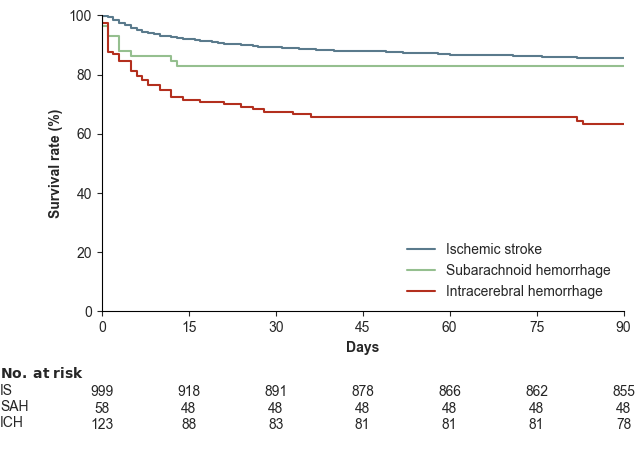

In [11]:
fig, ax = plt.subplots(1, 1)

AIS_label = 'Ischemic stroke'
AIS_color = '#5a7a8c'
AIS_kmf.plot(ax=ax, color=AIS_color, ci_show=False, label=AIS_label)

SAH_label = 'Subarachnoid hemorrhage'
SAH_color = '#95BF8F'
SAH_kmf.plot(ax=ax, color=SAH_color, ci_show=False, label=SAH_label)

ICH_label = 'Intracerebral hemorrhage'
ICH_color = '#b32f1e'
ICH_kmf.plot(ax=ax, color=ICH_color, ci_show=False, label=ICH_label)

# remove upper and right spine
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set axes
ax.set_ylim(0, 1)
ax.set_xlim(0, 90)

ax.set_xticks([0, 15, 30, 45, 60, 75, 89])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['0', '20', '40', '60', '80', '100'])
# show y ticks
ax.yaxis.set_ticks_position('left')

ax.set_ylabel('Survival rate (%)', fontdict={'fontweight': 'bold'})
ax.set_xlabel('Days', fontdict={'fontweight': 'bold'})

# Set legend
ax.legend(loc='lower right', frameon=False)

# Add at risk counts
short_AIS_label = 'IS'
short_SAH_label = 'SAH'
short_ICH_label = 'ICH'
add_at_risk_counts(AIS_kmf, SAH_kmf, ICH_kmf, labels=[short_AIS_label, short_SAH_label, short_ICH_label], rows_to_show=['At risk'],
                     ax=ax)
# change back xticks (last one is not counted otherwise)
ax.set_xticks([0, 15, 30, 45, 60, 75, 90])


# Update at risk count first column
at_risk_count_ax = fig.axes[-1]
at_risk_count_labels = at_risk_count_ax.get_xticklabels()
# remove labels in firs row
updated_at_risk_count_labels = [label.get_text()
                                    .replace('At risk', '')
                                    .replace(short_AIS_label, '')
                                    .replace(short_SAH_label, '')
                                    .replace(short_ICH_label, '')
                                    .replace(' ', '')
                                for label in at_risk_count_labels]
updated_at_risk_count_labels = updated_at_risk_count_labels
at_risk_count_ax.set_xticks(at_risk_count_ax.get_xticks().tolist()[:-1] + [at_risk_count_ax.get_xticks()[-1] + 1])
at_risk_count_ax.set_xticklabels(updated_at_risk_count_labels, ha='center')

# add first row
trans = transforms.blended_transform_factory(transforms.IdentityTransform(), at_risk_count_ax.transAxes)
bb = at_risk_count_ax.xaxis.majorTicks[0].label1.get_window_extent()
at_risk_first_row = (r"$\bf{" + "No." + "}$" + " " + r"$\bf{" + "at" + "}$" + " " + r"$\bf{" + "risk" + "}$" 
                     + f'\n{short_AIS_label}\n{short_SAH_label}\n{short_ICH_label}')
# if full label
# at_risk_count_ax.text(-1, -0.390, at_risk_first_row,ha='left', transform=trans)

# if short label
at_risk_count_ax.text(0, -0.390, at_risk_first_row,ha='left', transform=trans)

# add margin to the left of the plot
plt.subplots_adjust(left=0.12, right=0.85)

# turn off grid
ax.grid(False)
at_risk_count_ax.grid(False)

# x and y axis in black
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')

plt.tight_layout()

In [13]:
# fig.savefig('/Users/jk1/Downloads/kaplan_meier.pdf', dpi=600, bbox_inches='tight')